# CATE Inference Practice (CausalML-book)

- [CausalML(2022)](https://causalml-book.org/) 챕터 14의 Notebook을 간추려 소개합니다. (일부는 제 생각이 포함되어 있습니다) 가독성을 위해 일부 Cell은 숨겼으나, ipynb 코드를 다운로드 받으면 실행 가능합니다. 이번 실습은 {cite}`10.1093/poq/nfs036`의 논문을 참조하고 있습니다. 설문 데이터로, Welfare(복지)라는 단어에 대해 느끼는 미국 시민의 정서를 탐구하고 있습니다.
- 설문 대상은 두 그룹으로 나뉘어 비슷하지만 다른 질문을 받게 됩니다. 특히 "정부가 Welfare(복지)에 돈을 너무 많이 쓴다고 생각하나요?"와 "정부가 Assistance to the Poor(빈곤층 지원)에 돈을 너무 많이 쓴다고 생각하나요?"로 나뉘는 질문을 포함합니다. 설문 결과, 그렇다고 응답한 사람의 숫자는 전자에서 훨씬 많이 나왔습니다. (ATE 수준)
- 더 나아가서, 진보 성향, 교육 수준 등에 따라 질문을 달리하는 것의 효과가 어떻게 다른지 CATE estimation을 연습합니다.

# Setup

In [ ]:
!pip install econml

# hide

In [ ]:
!pip install wget

# hide

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.api import OLS
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_predict
import pandas as pd

# hide

In [16]:
import wget
import os

if os.path.exists('datasets.py'):
    os.remove('datasets.py')
wget.download('https://raw.githubusercontent.com/CausalAIBook/MetricsMLNotebooks/main/T/datasets.py')

if os.path.exists('myxgb.py'):
    os.remove('myxgb.py')
wget.download('https://raw.githubusercontent.com/CausalAIBook/MetricsMLNotebooks/main/T/myxgb.py')

# hide

'myxgb.py'

In [17]:
dataset = 'welfare'
# hide

In [79]:
from datasets import fetch_data_generator

verbose = 0  # verbosity of auto-ml
n_splits = 5  # cross-fitting and cross-validation splits
cfit = True
data = 'welfare'  # which dataset, one of {'401k', 'criteo', 'welfare', 'poverty', 'charity'}
plot = True  # whether to plot results

control_feats = 'all'  # list of subset of features to be used as confounders or the string 'all' for everything
# list of subset of control features to be used for CATE model or the string 'all' for all controls
hetero_feats = 'all'
cov_clip = .01  # clipping of treatment variance p(x)*(1-p(x)), whenever used in inverse propensities
binary_y = True
random_seed = 1

# treatment policy to evaluate
def policy(x):
    return x['polviews'] > 0

# For semi-synthetic data generation
semi_synth = False  # Whether true outcome y should be replaced by a fake outcome from a known CEF
simple_synth = True  # Whether the true CEF of the fake y should be simple or fitted from data
max_depth = 2  # max depth of random forest during for semi-synthetic model fitting
scale = .2  # magnitude of noise in semi-synthetic data


def simple_true_cef(D, X):  # simple CEF of the outcome for semi-synthetic data
    return .5 * np.array(X)[:, 1] * D + np.array(X)[:, 1]

get_data, _, _, _ = fetch_data_generator(data=data, semi_synth=semi_synth, simple_synth=simple_synth, scale=scale, true_f=simple_true_cef, max_depth=max_depth)
# hide

In [19]:
# Fetching Dataset
X, D, y, _ = get_data()

Y는 종속 변수 또는 타겟 변수, D는 관심 변수 또는 처치 변수(빈곤층 지원이라는 워딩을 썼는가?), X는 nuisance 변수로 생각할 수 있습니다. 우리는 오직 관심 변수 Y와 종속 변수 D 사이의 인과 관계를 알고 싶은데 X를 고려하지 않자니 편향이 발생해서 3가지가 존재하는 거예요.

(prediction model에서는 Y(Target Variable), X(Features) 2개로 나누는 것과 대조적입니다.)

In [20]:
D # 여기서 D = 1은 빈곤층 지원, D = 0은 복지라는 워딩 채택

array([0, 1, 1, ..., 1, 0, 1])

In [21]:
y # '나는 정부가 복지/빈곤층 지원에 너무 많은 돈을 쓴다고 생각한다.'에 대해 예: 1, 아니오: 0

array([1, 0, 0, ..., 0, 1, 0])

---

# Data Analysis and Simple OLS

In [22]:
X.head()

,hrs1,income,rincome,age,polviews,educ,earnrs,sibs,childs,occ80,...,marital_2.0,marital_3.0,marital_4.0,marital_5.0,race_2,race_3,mobile16_2.0,mobile16_3.0,sex_2,born_2.0
15617,60.0,12.0,11.0,47.0,4.0,18.0,3.0,0.0,3.0,869.0,...,False,False,False,False,False,False,False,True,False,False
15902,35.0,12.0,12.0,26.0,5.0,12.0,1.0,3.0,0.0,505.0,...,False,False,False,True,False,True,False,True,False,False
17984,40.0,12.0,12.0,28.0,4.0,16.0,1.0,2.0,0.0,19.0,...,False,False,False,True,False,False,True,False,False,False
5242,25.0,12.0,8.0,21.0,4.0,12.0,2.0,1.0,0.0,276.0,...,False,False,False,True,False,False,False,False,False,False
21557,45.0,12.0,12.0,60.0,3.0,12.0,2.0,0.0,3.0,19.0,...,False,False,False,False,False,False,True,False,False,False


In [23]:
X.describe() # 이 중, polviews는 정치 성향으로 1에서 7로 갈수록 보수적임.

,hrs1,income,rincome,age,polviews,educ,earnrs,sibs,childs,occ80,...,reg16,family16,parborn,maeduc,degree,hompop,babies,preteen,teens,adults
count,12907.000000,12907.000000,12907.000000,12907.000000,12907.000000,12907.000000,12907.000000,12907.000000,12907.000000,12907.000000,...,12907.000000,12907.000000,12907.000000,12907.000000,12907.000000,12907.000000,12907.000000,12907.000000,12907.000000,12907.000000
mean,42.260324,11.305183,10.223367,40.573952,4.083443,14.026497,1.745177,3.426823,1.569613,332.056016,...,4.417758,1.824669,0.886263,11.745874,1.758736,2.645619,0.227628,0.303479,0.216782,1.893004
std,14.018162,1.635527,2.744435,12.179377,1.376485,2.722665,0.830837,2.918114,1.482378,242.739687,...,2.619726,1.662529,2.418884,3.313779,1.177910,1.399372,0.546265,0.656729,0.527373,0.774679
min,0.000000,1.000000,1.000000,18.000000,1.000000,0.000000,0.000000,0.000000,0.000000,4.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,38.000000,12.000000,9.000000,31.000000,3.000000,12.000000,1.000000,2.000000,0.000000,156.000000,...,2.000000,1.000000,0.000000,11.000000,1.000000,2.000000,0.000000,0.000000,0.000000,1.000000
50%,40.000000,12.000000,12.000000,40.000000,4.000000,14.000000,2.000000,3.000000,2.000000,305.000000,...,4.000000,1.000000,0.000000,12.000000,1.000000,2.000000,0.000000,0.000000,0.000000,2.000000
75%,50.000000,12.000000,12.000000,49.000000,5.000000,16.000000,2.000000,4.000000,2.000000,458.000000,...,6.500000,1.000000,0.000000,13.000000,3.000000,4.000000,0.000000,0.000000,0.000000,2.000000
max,89.000000,12.000000,12.000000,88.000000,7.000000,20.000000,8.000000,37.000000,8.000000,889.000000,...,9.000000,8.000000,8.000000,20.000000,4.000000,11.000000,4.000000,5.000000,4.000000,8.000000


In [24]:
X = X - X.mean(axis=0)

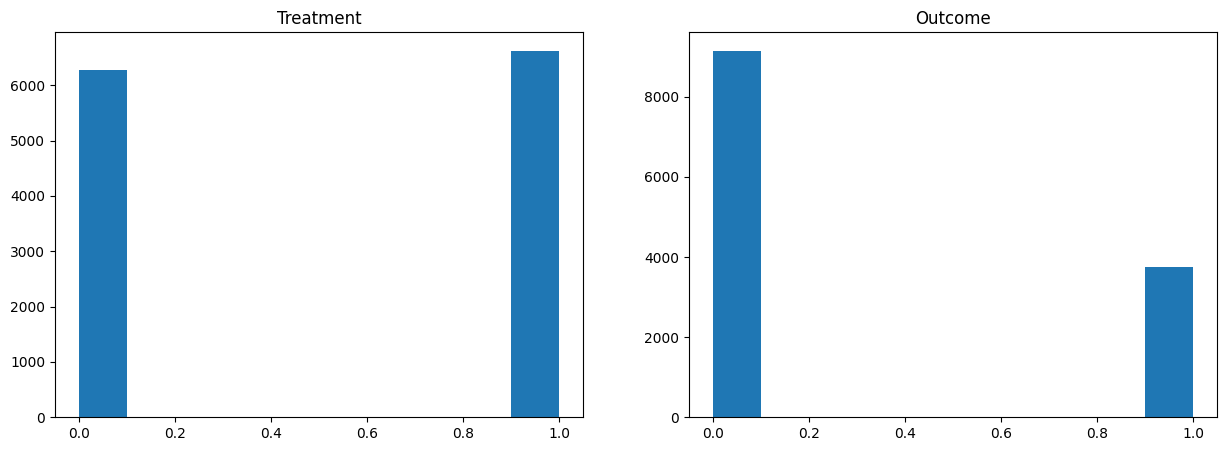

In [25]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.hist(D)
plt.title('Treatment')
plt.subplot(1, 2, 2)
plt.hist(y)
plt.title('Outcome')
plt.show()

In [ ]:
import statsmodels.formula.api as smf

model = smf.ols(formula="y ~ D", data=X).fit(cov_type='HC1')
print(model.summary())

# 만약 Random Trial이 아니라면 Selection Bias를 이 방법으로는 배제할 수 없음.

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.164
Model:                            OLS   Adj. R-squared:                  0.164
Method:                 Least Squares   F-statistic:                     2476.
Date:                Tue, 18 Mar 2025   Prob (F-statistic):               0.00
Time:                        17:22:57   Log-Likelihood:                -6969.7
No. Observations:               12907   AIC:                         1.394e+04
Df Residuals:                   12905   BIC:                         1.396e+04
Df Model:                           1                                         
Covariance Type:                  HC1                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.4798      0.006     76.111      0.0

---

# Doubly-Robust ATE Estimation and CATE Estimation

## Define and Estimate

Doubly-Robust Estimator에 대한 정의에 앞서, 몇 가지 함수 및 추정치를 정의해보겠습니다. 우리는 D=0인 Control Group 내부에서 모든 변수(X와 D=0)로 y를 예측하는 모델을 만들 수 있습니다. D = 1에 대해서도 마찬가지로 모델을 만들 수 있겠죠. 만약 두 그룹이 비교 가능하다면 이것만으로도 제법 괜찮은 모델일 수도 있겠네요. (물론 일부 Learner의 경우, 수많은 공변량에서 차원의 저주에 의해 D가 0이든 1이든 효과가 고려되지 않고 X에만 의존하여 예측치를 만들어 실제 효과가 있는 정책임에도 underestimate될 확률이 있을 수 있겠습니다.)

\begin{align}
g_0(x) := E[Y\mid D=0, X=x]\\
g_1(x) := E[Y\mid D=1, X=x]\\
g_{D_i} := g_1(x) * D + g_0(x) * (1-D)\\
\end{align}


또 성향점수 모델 p(x)도 아래와 같이 만들 수 있습니다. q(x)의 경우 D 변수를 사용하지 않고 Y를 예측하는 모델입니다. (DML이나 Causal Forest에서 활용되는 잔차화 방식을 위해 쓰입니다.)

\begin{align}
p(x) := E[D\mid X=x] = \Pr(D=1\mid X=x)\\
q(x) := E[Y\mid X=x]\\
\end{align}

여기서 설명한 모든 추정치를 얻기 위해서는, 원하는 머신러닝을 골라서 사용할 수 있습니다. 단, 오버피팅 문제로 이런 방법을 쓸 때는 반드시 cross-validation을 하는 것이 하나의 규칙입니다. 본 노트북에서는 주로 XGBoost Regression을 사용합니다.

이제 아래와 같이 $Y_i^{DR}$ 함수를 만들고, 이의 기대값을 구하는 방법으로 ATE를 추정할 수 있습니다. 여기서 Doubly Robust라고 부르는 이유는, 성향점수 추정치 $\hat{p}(X_i)$가 부정확하더라도 $\hat{g}_1(X_i)$와 $\hat{g}_0(X_i)$만 정확하면 기댓값이 곧 올바른 ATE의 추정치가 되고, 반대로 $\hat{g}_1(X_i)$와 $\hat{g}_0(X_i)$가 부정확하더라도 성향점수 추정치 $\hat{p}(X_i)$가 정확하다면 마찬가지로 기댓값이 곧 올바른 ATE의 추정치가 되기 때문입니다.

Doubly Robust Estimator는 다음과 같이 정의됩니다.

\begin{align}
Y_i^{DR}(\hat{g},\hat{p}) := \hat{g}_1(X_i) - \hat{g}_0(X_i) + (Y_i - \hat{g}_{D_i}(X_i))\frac{D_i - \hat{p}(X_i)}{\hat{p}(X_i) (1-\hat{p}(X_i))}
\end{align}

이후 다음과 같이 활용될 수 있습니다.

\begin{align}
ATE = E_n\left[Y^{DR}(\hat{g},\hat{p})\right], CATE = \tau(X) = E[Y^{DR}(\hat{g}, \hat{p})|X]
\end{align}

증명은 [링크](/doubly-robust-estimator)를 참고해주세요.

In [27]:
# 저자가 만든 함수를 활용함. xgboost에서는 0/1의 이진분류를 제공하지 않기 때문에 Wrapper를 따로 만들어 활용함.

from myxgb import xgb_reg, xgb_clf, RegWrapper

def auto_reg():
    return xgb_reg(random_seed)

def auto_clf():
    return RegWrapper(xgb_clf(random_seed))

modely = auto_clf if binary_y else auto_reg

In [29]:
if cfit:
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_seed)
    stratification_label = 2 * D + y if binary_y else D
    splits = list(cv.split(X, stratification_label))
else:
    splits = [(np.arange(X.shape[0]), np.arange(X.shape[0]))]

n = X.shape[0]
reg_preds_t = np.zeros(n)
reg_zero_preds_t = np.zeros(n)
reg_one_preds_t = np.zeros(n)

for train, test in splits:
    reg_zero = modely().fit(X.iloc[train][D[train] == 0], y[train][D[train] == 0]) 
    reg_one = modely().fit(X.iloc[train][D[train] == 1], y[train][D[train] == 1]) 
    
    reg_zero_preds_t[test] = reg_zero.predict(X.iloc[test]) # (y ~ X | D==0), xgboost
    reg_one_preds_t[test] = reg_one.predict(X.iloc[test]) # (y ~ X | D==1), xgboost
    reg_preds_t[test] = reg_zero_preds_t[test] * (1 - D[test]) + reg_one_preds_t[test] * D[test] # Combine above two

res_preds = cross_val_predict(modely(), X, y, cv=splits) # (y ~ X) with CV, xgboost
prop_preds = cross_val_predict(auto_clf(), X, D, cv=splits) # (D ~ X) with CV, xgboost

In [30]:
def r2score(y, ypred):
    return 1 - np.mean((y - ypred)**2) / np.var(y)

print(f"R^2 of model for (y ~ X): {r2score(y, res_preds):.4f}")
print(f"R^2 of model for (D ~ X): {r2score(D, prop_preds):.4f}")
print(f"R^2 of model for (y ~ X | D==0): {r2score(y[D==0], reg_zero_preds_t[D==0]):.4f}")
print(f"R^2 of model for (y ~ X | D==1): {r2score(y[D==1], reg_one_preds_t[D==1]):.4f}")
print(f"R^2 of model for (y ~ X, D): {r2score(y, reg_preds_t):.4f}")

R^2 of model for (y ~ X): 0.0458
R^2 of model for (D ~ X): -0.0002
R^2 of model for (y ~ X | D==0): 0.0690
R^2 of model for (y ~ X | D==1): 0.0375
R^2 of model for (y ~ X, D): 0.2140


## ATE

In [32]:
dr_preds = reg_one_preds_t - reg_zero_preds_t
dr_preds += (y - reg_preds_t) * (D - prop_preds) / np.clip(prop_preds * (1 - prop_preds), cov_clip, np.inf)

ate = np.mean(dr_preds)
print(f"ATE: {ate:.4f}")

ATE: -0.3660


## CATE

### (1) 그냥 추정하기

만약 우리가 만든 Y_{DR}을 종속변수로 하여 OLS 돌리면 CATE를 뽑을 수 있습니다. 출력 결과의 coefficients가 설명하는 것은, 예를 들어 X1이 1 증가하면, ATE가 얼마나 증가하냐를 추정합니다. CATE가 크면, 해당 변수가 증가할수록 정책의 효과가 크게 적용된다고 해석할 수 있습니다. RCT라면, y ~ D + D * X1에서 얻는 2번째 계수와 거의 비슷한 값을 얻을 것입니다.

In [39]:
dfX = X.copy()
dfX['const'] = 1
lr = OLS(dr_preds, dfX).fit(cov_type='HC1')
cov = lr.get_robustcov_results(cov_type='HC1')
print(lr.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.015
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     5.090
Date:                Tue, 18 Mar 2025   Prob (F-statistic):           1.29e-24
Time:                        19:35:07   Log-Likelihood:                -15618.
No. Observations:               12907   AIC:                         3.132e+04
Df Residuals:                   12864   BIC:                         3.164e+04
Df Model:                          42                                         
Covariance Type:                  HC1                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
hrs1            -0.0018      0.001     -2.679   

In [42]:
# OLS로 income의 CATE를 얻고, 비슷한지 살펴봅시다.

df_cate_by_ols = X.copy()
df_cate_by_ols['y'] = y
df_cate_by_ols['D'] = D
df_cate_by_ols['D_income'] = D * df_cate_by_ols["income"]
model = smf.ols(formula="y ~ D + income + D_income", data=df_cate_by_ols).fit(cov_type='HC1')
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.169
Model:                            OLS   Adj. R-squared:                  0.169
Method:                 Least Squares   F-statistic:                     857.8
Date:                Tue, 18 Mar 2025   Prob (F-statistic):               0.00
Time:                        19:38:40   Log-Likelihood:                -6933.5
No. Observations:               12907   AIC:                         1.388e+04
Df Residuals:                   12903   BIC:                         1.390e+04
Df Model:                           3                                         
Covariance Type:                  HC1                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.4795      0.006     76.345      0.0

income에 대한 CATE. Doubly Robust y 추정치에 대한 income의 OLS 계수와 값이 기대와 같이 거의 비슷합니다.

### (2) Confidence Interval과 함께 CATE 추정하기

아래는 joint inference를 기반으로 Confidence Interval과 함께 CATE를 보는 것입니다.

In [22]:
V = cov.cov_params()
S = np.diag(np.diagonal(V)**(-1 / 2))
epsilon = np.random.multivariate_normal(np.zeros(V.shape[0]), S @ V @ S, size=(1000))
critical = np.percentile(np.max(np.abs(epsilon), axis=1), 95)
stderr = np.diagonal(V)**(1 / 2)
lb = cov.params - critical * stderr
ub = cov.params + critical * stderr
jointsummary = pd.DataFrame({'coef': cov.params,
                             'std err': stderr,
                             'lb': lb,
                             'ub': ub,
                             'statsig': ['' if ((l <= 0) & (0 <= u)) else '**' for (l, u) in zip(lb, ub)]},
                            index=dfX.columns)
jointsummary

,coef,std err,lb,ub,statsig
hrs1,-0.001809,0.000675,-0.003996,0.000377,
income,-0.011030,0.005612,-0.029202,0.007142,
rincome,-0.004747,0.003779,-0.016984,0.007491,
age,0.000504,0.000840,-0.002215,0.003223,
polviews,-0.021687,0.005975,-0.041034,-0.002341,**
educ,0.000293,0.005695,-0.018146,0.018732,
earnrs,0.006672,0.012223,-0.032905,0.046249,
sibs,0.002066,0.002696,-0.006665,0.010797,
childs,0.004955,0.006842,-0.017198,0.027108,
occ80,-0.000053,0.000042,-0.000190,0.000083,


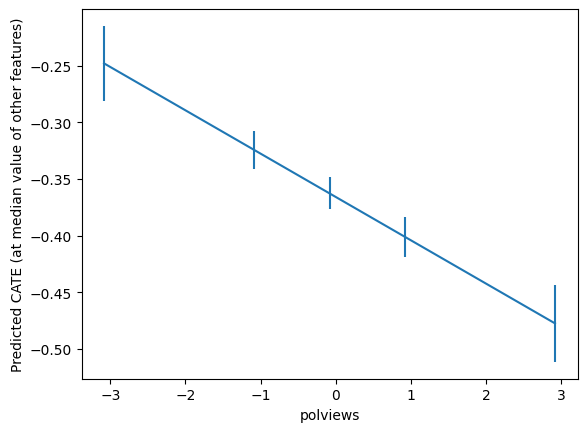

In [50]:
grid = np.unique(np.percentile(dfX['polviews'], np.arange(0, 110, 20)))

Zpd = pd.DataFrame(np.tile(np.median(dfX, axis=0, keepdims=True), (len(grid), 1)),
                   columns=dfX.columns)
Zpd['polviews'] = grid

pred_df = lr.get_prediction(Zpd).summary_frame()
preds, lb, ub = pred_df['mean'].values, pred_df['mean_ci_lower'].values, pred_df['mean_ci_upper'].values
preds = preds.flatten()
lb = lb.flatten()
ub = ub.flatten()
plt.errorbar(Zpd['polviews'], preds, yerr=(preds - lb, ub - preds))
plt.xlabel('polviews')
plt.ylabel('Predicted CATE (at median value of other features)')
plt.show()

# Simpler Best Linear Projections of CATE

이런 것도 가능합니다.

1. polviews가 가진 값이 7가지인데, 각 값마다 CATE와 Confidence Interval를 볼 수 있을 것 같아요.
2. polviews가 연속변수라면 CATE가 어떻게 변할지를 근사적으로 나타내볼 수 있을 것 같아요.

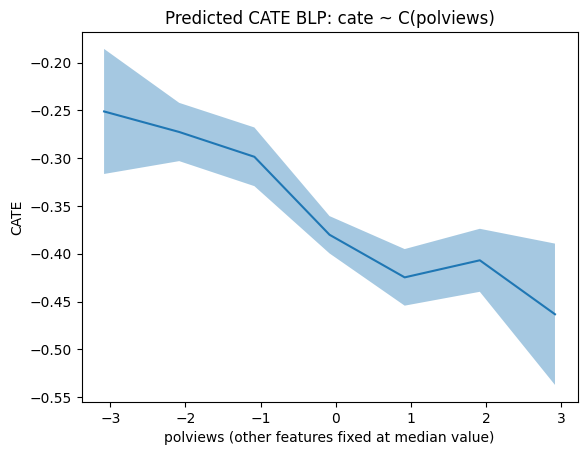

In [61]:
from statsmodels.formula.api import ols
df = X.copy()
df['dr'] = dr_preds
lr = ols('dr ~ C(polviews)', df).fit(cov_type='HC1')

grid = np.unique(np.percentile(X['polviews'], np.arange(0, 102, 2)))
Xpd = pd.DataFrame(np.tile(np.median(X, axis=0, keepdims=True), (len(grid), 1)),
                   columns=X.columns)
Xpd['polviews'] = grid
pred_df = lr.get_prediction(Xpd).summary_frame(alpha=.1)

plt.plot(Xpd['polviews'], pred_df['mean'])
plt.fill_between(Xpd['polviews'], pred_df['mean_ci_lower'], pred_df['mean_ci_upper'], alpha=.4)
plt.xlabel('polviews' + ' (other features fixed at median value)')
plt.title('Predicted CATE BLP: cate ~ C(polviews)')
plt.ylabel('CATE')
plt.show()

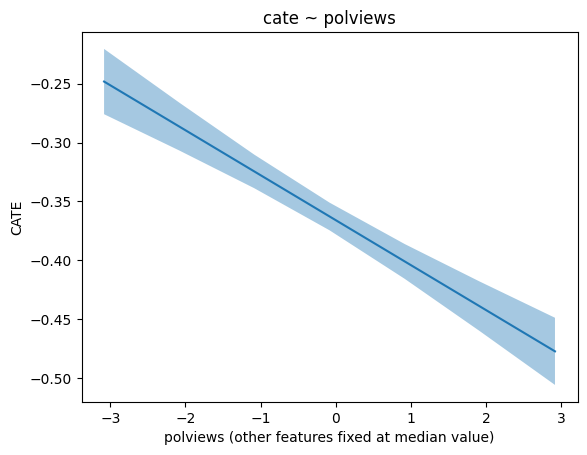

In [62]:
from statsmodels.formula.api import ols
df = X.copy()
df['dr'] = dr_preds
lr = ols('dr ~ polviews', df).fit(cov_type='HC1')

grid = np.unique(np.percentile(X['polviews'], np.arange(0, 102, 2)))
Xpd = pd.DataFrame(np.tile(np.median(X, axis=0, keepdims=True), (len(grid), 1)),
                   columns=X.columns)
Xpd['polviews'] = grid
pred_df2 = lr.get_prediction(Xpd).summary_frame(alpha=.1)

plt.plot(Xpd['polviews'], pred_df2['mean'])
plt.fill_between(Xpd['polviews'], pred_df2['mean_ci_lower'], pred_df2['mean_ci_upper'], alpha=.4)
plt.xlabel('polviews' + ' (other features fixed at median value)')
plt.ylabel('CATE')
plt.title('cate ~ polviews' )
plt.show()

# Non-Parametric Confidence Intervals on CATE Predictions

선형 모델 말고, 이제 비모수적 CATE 예측을 해봅시다. 보통 Causal Forests 또는 Doubly Robust Forests라고 불리는 접근을 사용합니다

## Causal Forests

In [68]:
Z = X

In [67]:
min_samples_leaf = 50
max_samples = .4

In [69]:
from econml.grf import CausalForest

yres = y - res_preds # res_preds: (y ~ X) with CV, xgboost
Dres = D - prop_preds # prop_preds: (D ~ X) with CV, xgboost
cf = CausalForest(4000, criterion='het', max_depth=None,
                  max_samples=.4,
                  min_samples_leaf=50,
                  min_weight_fraction_leaf=.0,
                  random_state=random_seed)
cf.fit(Z, Dres, yres)

CausalForest(criterion='het', max_samples=0.4, min_samples_leaf=50,
             n_estimators=4000, random_state=1)

In [70]:
top_feat = np.argsort(cf.feature_importances_)[-1]
print(Z.columns[top_feat])

polviews


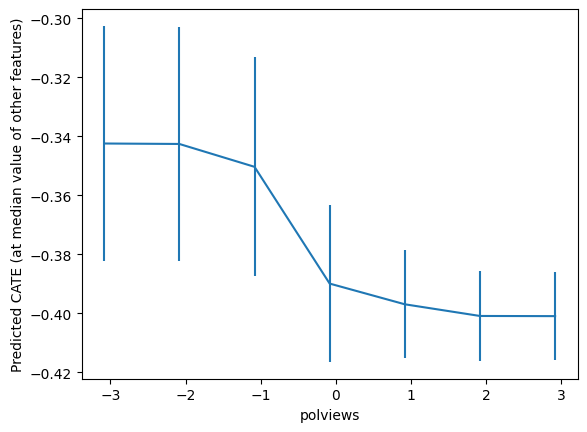

In [71]:
grid = np.unique(np.percentile(Z.iloc[:, top_feat], np.arange(0, 105, 5)))
Zpd = pd.DataFrame(np.tile(np.median(Z, axis=0, keepdims=True), (len(grid), 1)),
                   columns=Z.columns)
Zpd.iloc[:, top_feat] = grid

preds, lb, ub = cf.predict(Zpd, interval=True, alpha=.1)
preds = preds.flatten()
lb = lb.flatten()
ub = ub.flatten()
plt.errorbar(Zpd.iloc[:, top_feat], preds, yerr=(preds - lb, ub - preds))
plt.xlabel(Zpd.columns[top_feat])
plt.ylabel('Predicted CATE (at median value of other features)')
plt.show()

In [72]:
important_feats = Z.columns[np.argsort(cf.feature_importances_)[::-1]]
important_feats[:4]

Index(['polviews', 'indus80', 'educ', 'hrs1'], dtype='object')

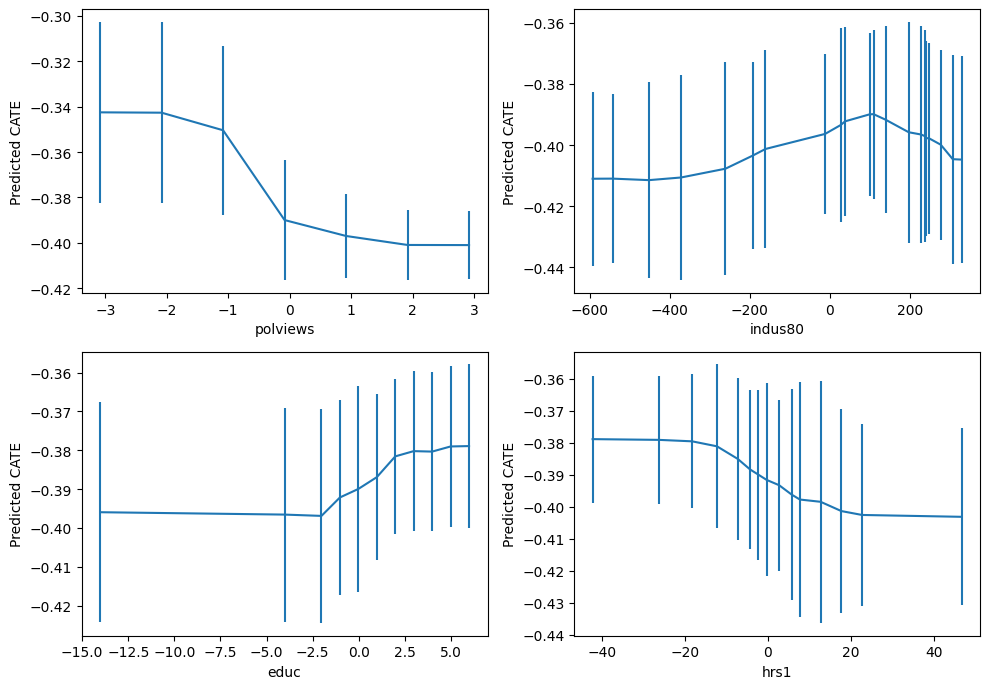

In [73]:
plt.figure(figsize=(10, 7))
for it, feature in enumerate(important_feats[:4]):
    plt.subplot(2, 2, it + 1)
    grid = np.unique(np.percentile(Z[feature], np.arange(0, 105, 5)))
    Zpd = pd.DataFrame(np.tile(np.median(Z, axis=0, keepdims=True), (len(grid), 1)),
                       columns=Z.columns)
    Zpd[feature] = grid

    preds, lb, ub = cf.predict(Zpd, interval=True, alpha=.1)
    preds = preds.flatten()
    lb = lb.flatten()
    ub = ub.flatten()
    plt.errorbar(Zpd[feature], preds, yerr=(preds - lb, ub - preds))
    plt.xlabel(feature)
    plt.ylabel('Predicted CATE')
plt.tight_layout()
plt.show()

## Doubly Robust Forests

In [74]:
from econml.grf import RegressionForest

drrf = RegressionForest(4000, max_depth=5,
                        max_samples=.4,
                        min_samples_leaf=50,
                        min_weight_fraction_leaf=.0,
                        random_state=random_seed)
drrf.fit(Z, dr_preds)

RegressionForest(max_depth=5, max_samples=0.4, min_samples_leaf=50,
                 n_estimators=4000, random_state=1)

In [75]:
top_feat = np.argsort(drrf.feature_importances_)[-1]
print(Z.columns[top_feat])

polviews


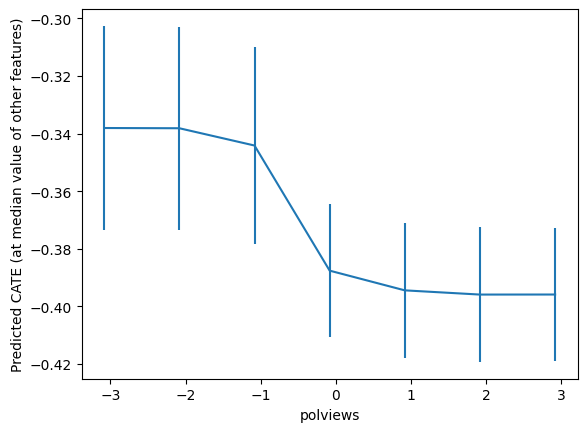

In [76]:
grid = np.unique(np.percentile(Z.iloc[:, top_feat], np.arange(0, 105, 5)))
Zpd = pd.DataFrame(np.tile(np.median(Z.values, axis=0, keepdims=True), (len(grid), 1)),
                   columns=Z.columns)
Zpd.iloc[:, top_feat] = grid

preds, lb, ub = drrf.predict(Zpd, interval=True, alpha=.1)
preds = preds.flatten()
lb = lb.flatten()
ub = ub.flatten()
plt.errorbar(Zpd.iloc[:, top_feat], preds, yerr=(preds - lb, ub - preds))
plt.xlabel(Zpd.columns[top_feat])
plt.ylabel('Predicted CATE (at median value of other features)')
plt.show()

In [77]:
important_feats = Z.columns[np.argsort(drrf.feature_importances_)[::-1]]
important_feats[:4]

Index(['polviews', 'indus80', 'educ', 'hrs1'], dtype='object')

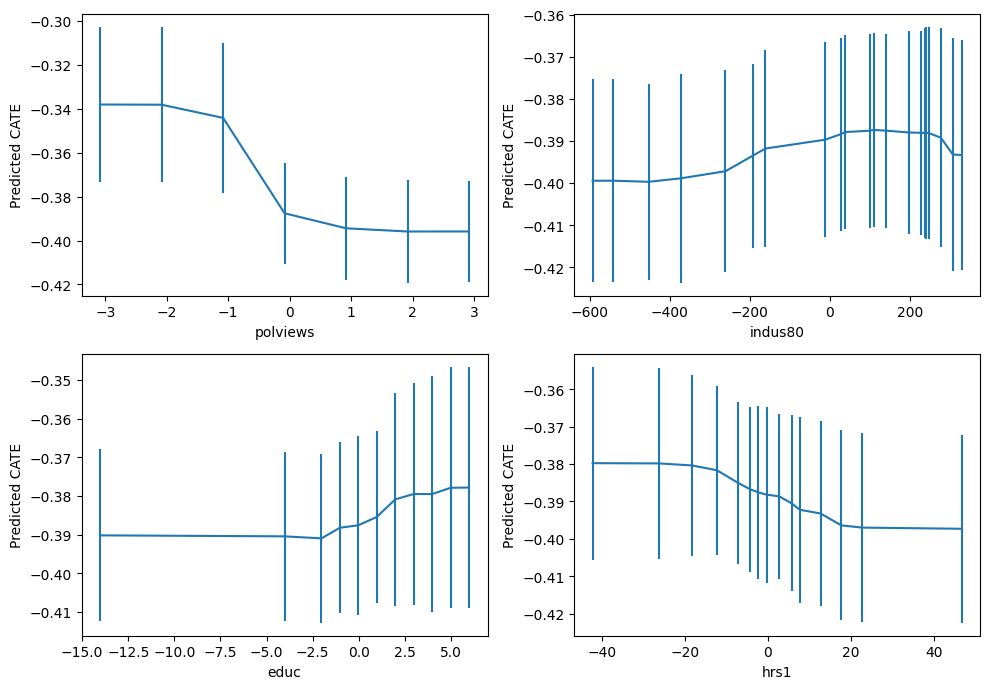

In [78]:
plt.figure(figsize=(10, 7))
for it, feature in enumerate(important_feats[:4]):
    plt.subplot(2, 2, it + 1)
    grid = np.unique(np.percentile(Z[feature], np.arange(0, 105, 5)))
    Zpd = pd.DataFrame(np.tile(np.median(Z, axis=0, keepdims=True), (len(grid), 1)),
                       columns=Z.columns)
    Zpd[feature] = grid

    preds, lb, ub = drrf.predict(Zpd, interval=True, alpha=.1)
    preds = preds.flatten()
    lb = lb.flatten()
    ub = ub.flatten()
    plt.errorbar(Zpd[feature], preds, yerr=(preds - lb, ub - preds))
    plt.xlabel(feature)
    plt.ylabel('Predicted CATE')
plt.tight_layout()
plt.show()

# Policy Evaluation

만약 'Welfare'라는 단어에 대한 부정적 인식을 낮추기 위해 단어를 변경하는 노력이 비용이 든다고 가정해봅시다. treatment cost와 정책의 효용가치는 trade-offs 관계를 만듭니다. 여기서는 간단하게 treatment cost를 treatment effect와 같은 단위로 두어 비교가 쉽게 해보겠습니다. ATE인 -0.36보다도 훨씬 비용이 크다면, CATE를 고려하여 일부에게만 적절히 treat하는 것이 가성비가 좋을 것이고, 비용이 크지 않다면 오히려 모두에게 균일한 처치를 수행하는 것이 나을 수 있는 것을 확인할 수 있습니다.

In [80]:
def policy(x):
    return x['polviews'] > 0

#### Low Cost

In [88]:
# treating by personized policy when cost is low

treatment_cost = -.3

pi = (dr_preds - treatment_cost) * policy(Z)
score_personalized_low = np.mean(pi)
stderr = np.sqrt(np.var(pi) / pi.shape[0])
print(f"이익: {score_personalized_low:.5f}, 표준편차: {stderr:.5f}, 95% CI: {score_personalized_low - 1.96 * stderr:.5f}, {score_personalized_low + 1.96 * stderr:.5f}")

이익: -0.04181, 표준편차: 0.00449, 95% CI: -0.05061, -0.03301


In [89]:
# treating everyone when cost is low

treatment_cost = -.3

pi = (dr_preds - treatment_cost)
score_everyone_low = np.mean(pi)
stderr = np.sqrt(np.var(pi) / pi.shape[0])
print(f"이익: {score_everyone_low:.5f}, 표준편차: {stderr:.5f}, 95% CI: {score_everyone_low - 1.96 * stderr:.5f} ~ {score_everyone_low + 1.96 * stderr:.5f}")

이익: -0.06601, 표준편차: 0.00720, 95% CI: -0.08012 ~ -0.05191


In [95]:
print("이렇게 비용이 낮은 경우에는,")
if score_personalized_low < score_everyone_low:
    print("personalized treatment가 더 좋은 정책입니다.")
else:
    print("모두에게 처치하는 것이 더 좋은 정책입니다.")


이렇게 비용이 낮은 경우에는,
모두에게 처치하는 것이 더 좋은 정책입니다.


#### High Cost

In [91]:
# treating by personized policy when cost is high

treatment_cost = -.4

pi = (dr_preds - treatment_cost) * policy(Z)
score_personalized_high = np.mean(pi)
stderr = np.sqrt(np.var(pi) / pi.shape[0])
print(f"이익: {score_personalized_high:.5f}, 표준편차: {stderr:.5f}, 95% CI: {score_personalized_high - 1.96 * stderr:.5f} ~ {score_personalized_high + 1.96 * stderr:.5f}")

이익: -0.00706, 표준편차: 0.00446, 95% CI: -0.01580 ~ 0.00169


In [92]:
# treating everyone when cost is high

treatment_cost = -.4

pi = (dr_preds - treatment_cost)
score_everyone_high = np.mean(pi)
stderr = np.sqrt(np.var(pi) / pi.shape[0])
print(f"이익: {score_everyone_high:.5f}, 표준편차: {stderr:.5f}, 95% CI: {score_everyone_high - 1.96 * stderr:.5f} ~ {score_everyone_high + 1.96 * stderr:.5f}")

이익: 0.03399, 표준편차: 0.00720, 95% CI: 0.01988 ~ 0.04809


In [94]:
print("이렇게 비용이 높은 경우에는,")
if score_personalized_high < score_everyone_high:
    print("personalized treatment가 더 좋은 정책입니다.")
else:
    print("모두에게 처치하는 것이 더 좋은 정책입니다.")


이렇게 비용이 높은 경우에는,
personalized treatment가 더 좋은 정책입니다.
